<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/Splitter_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 1.x

In [0]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 156 (delta 73), reused 66 (delta 24), pack-reused 0
Receiving objects: 100% (156/156), 47.09 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os
from tqdm import trange

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# adapted from Keith Ito's tacotron implementation
# https://github.com/keithito/tacotron/blob/master/util/audio.py

import librosa
import numpy as np


class Audio():
    def __init__(self):
        self.ref_level_db = 20.0
        self.n_fft = 1200
        self.hop_length = 160
        self.win_length = 400
        self.min_level_db = -100.0

    def wav2spec(self, y):
        D = self.stft(y)
        S = self.amp_to_db(np.abs(D)) - self.ref_level_db
        S, D = self.normalize(S), np.angle(D)
        S, D = S.T, D.T # to make [time, freq]
        return S, D

    def spec2wav(self, spectrogram, phase):
        spectrogram, phase = spectrogram.T, phase.T
        # used during inference only
        # spectrogram: enhanced output
        # phase: use noisy input's phase, so no GLA is required
        S = self.db_to_amp(self.denormalize(spectrogram) + self.ref_level_db)
        return self.istft(S, phase)

    def stft(self, y):
        return librosa.stft(y=y, n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length)

    def istft(self, mag, phase):
        stft_matrix = mag * np.exp(1j*phase)
        return librosa.istft(stft_matrix,
                             hop_length=self.hop_length,
                             win_length=self.win_length)

    def amp_to_db(self, x):
        return 20.0 * np.log10(np.maximum(1e-5, x))

    def db_to_amp(self, x):
        return np.power(10.0, x * 0.05)

    def normalize(self, S):
        return np.clip(S / -self.min_level_db, -1.0, 0.0) + 1.0

    def denormalize(self, S):
        return (np.clip(S, 0.0, 1.0) - 1.0) * -self.min_level_db

audio = Audio()

In [0]:
embedding_matrix = np.asarray([[ 0.67218363, -1.6871625 ,  0.39094335,  0.45416522,  3.060402  ,
        -2.87009   , -0.29556486, -1.8322845 ,  2.287039  , -1.5228181 ,
         2.8732414 ,  2.1143398 , -3.355237  , -0.4983314 , -2.6186857 ,
         1.3060979 , -0.8364598 , -0.9532552 , -0.22835416,  0.8867765 ,
         1.5227174 ,  1.2176653 , -0.9880353 , -0.32890812,  2.618597  ,
        -2.7140734 , -2.3689802 ,  0.7710235 ,  1.9084004 ,  0.8810432 ,
         2.6237597 , -2.6608293 ],
         [-0.8265083 , -1.6049656 ,  1.5085448 ,  0.6589694 ,  2.1224942 ,
         2.3647609 ,  0.11735925,  1.1543381 ,  0.99229884,  1.4278704 ,
         0.5712279 , -1.5206277 ,  0.30854183, -2.6490169 ,  1.3902934 ,
        -0.23975304,  0.94975144, -2.0093975 ,  0.17497058, -1.0554106 ,
        -2.172874  , -1.5222347 ,  0.563387  ,  2.239781  , -0.96120906,
        -0.42689592,  2.4739625 , -2.362247  , -0.98188835,  0.16969077,
        -0.6247616 ,  0.04511972],
        [ 0.0985966 ,  0.9150637 ,  2.2399673 , -2.6504104 , -1.3134806 ,
        -1.8142706 , -0.18147974, -1.2972969 , -1.2393317 ,  1.5120008 ,
         0.9399936 , -0.15138409,  1.557585  ,  0.6709012 , -2.143024  ,
         1.276797  , -0.5063797 ,  2.5019035 ,  0.11260484,  1.5303274 ,
         1.7554147 ,  1.4767547 ,  2.4642498 ,  1.399184  , -1.5406029 ,
         2.0078533 ,  0.1091506 ,  1.1654673 ,  0.0777089 ,  1.4040853 ,
        -0.7952607 , -0.1732147 ],
        [ 0.47638106,  1.8903663 , -2.9872196 ,  2.3670852 , -2.4623342 ,
         2.220159  ,  0.23939389,  1.5010741 , -0.7784126 , -0.54998654,
        -2.0378437 , -0.07159348,  0.3601075 ,  1.7380389 ,  2.3474126 ,
        -1.0004979 ,  0.47312295, -0.88486624,  0.18921344, -0.43055353,
         0.38867134,  0.00616272, -3.2682106 , -2.6373188 ,  2.909382  ,
         0.7305331 , -1.1071701 ,  0.9580342 , -1.1098799 , -1.7031851 ,
         0.00362744,  2.3521018 ]
         ])

In [0]:
embedding_matrix.shape

(4, 32)

In [0]:
import math
import tensorflow as tf

def trunk_network(conv_size = 64, LSTM_size = 400, input_size = (51, 601), dropout_rate = 0.3):
    inputs = tf.keras.layers.Input(input_size)

    speaker_embeddings = tf.keras.Input(shape=(1, 32), dtype=tf.float32)
    
    x = tf.keras.layers.Reshape((input_size[0],  input_size[1], 1))(inputs)
    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn1
    # x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn2
    # x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # # cnn4
    # x = tf.keras.layers.ZeroPadding2D(padding=((4, 4), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(2, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # pdb.set_trace()

    # # cnn5
    # x = tf.keras.layers.ZeroPadding2D(padding=((8, 8), (2, 2)))(x)     
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(4, 1))(x)       
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn6
    # x = tf.keras.layers.ZeroPadding2D(padding=((16, 16), (2, 2)))(x)                 
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(8, 1))(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn7 TensorShape([None, 51, 601, conv_size])
    # x = tf.keras.layers.ZeroPadding2D(padding=((32, 32), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(16, 1))(x)     
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # cnn8 TensorShape([None, 51, 601, 8])
    x = tf.keras.layers.Conv2D(8, (1, 1))(x)     
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    'Reshape x shape TensorShape([None, 51, 4808])'
    # x = tf.keras.layers.Reshape((tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]*tf.keras.backend.int_shape(x)[3]))(x)
    x = tf.keras.layers.Reshape((51, 4808))(x)
    repeat_embedding_time_wise = tf.tile(speaker_embeddings, [1, 51, 1])
    
    x = tf.keras.layers.concatenate([x, repeat_embedding_time_wise],axis=-1)
    # LSTM 1
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
    x = tf.keras.layers.Dropout(dropout_rate)(x)                        

    # # LSTM 2 TensorShape([None, 51, 800])                                           
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
                            
    x = tf.keras.layers.ReLU()(x)
    # Dense 1
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1]))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Dense 2
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1], activation='sigmoid'))(x)

    output = tf.keras.layers.Multiply()([inputs, mask])
    # print(output.shape)
    model = tf.keras.Model(inputs=[inputs, speaker_embeddings], outputs=[output])
    return model

'learning rate decay'
def step_decay(epoch):
    # initial_lrate = 0.0001
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

### Prepare data

In [0]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = trunk_network(conv_size = 64, LSTM_size = 400)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=['mse'])
  lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

INFO:tensorflow:Initializing the TPU system: grpc://10.77.97.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.97.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 51, 601)]    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 51, 601, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 51, 607, 1)   0           reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 51, 601, 64)  512         zero_padding2d_6[0][0]           
____________________________________________________________________________________________

In [0]:
# The batch iterator
class BatchIterator:
    def __init__(self, data, label, spk_label, batch_size, is_shuffle):
        data = np.asarray(data)
        label = np.asarray(label)
        self.spk_label = np.asarray(spk_label)
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.cursor = 0
        self.size = data.shape[0]
        self.order = np.arange(self.size)
        self.shuffled = False
        if is_shuffle:
            self.shuffle()

    def shuffle(self):
        np.random.shuffle(self.order)
        # print "Batch shuffled"
        self.cursor = 0

    def next(self):
        if self.shuffled==True:
            self.shuffled = False
        if self.cursor + self.batch_size > self.size:
            self.shuffle()
            self.shuffled = True
        idx = self.order[self.cursor:self.cursor + self.batch_size]
        self.cursor += self.batch_size
        return self.data[idx], self.label[idx], self.spk_label[idx]

In [0]:
def evaluate_results(model, X_test, y_test, test_label):
  test_res = model.predict([X_test, test_label])
  mse = (np.square(test_res - y_test)).mean(axis=None)
  return mse

In [0]:
model.load_weights(f'gdrive/My Drive/Spitter_VTB/four_speaker.h5')

In [0]:
# Baby sitter: at 128 iter, changed lr from 0.001 to 1e-4
iterations = 128
# iterations = 32
X_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_test_case/cycle_mixed_mag_list.npy")
y_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_test_case/cycle_target_mag_list.npy")
test_label = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_test_case/cycle_speaker_label.npy")

test_label = np.expand_dims(np.matmul(np.eye(4)[np.asarray(test_label)], embedding_matrix), axis=1)
data_counter = 0
with trange(iterations) as t:
  for iteration in t:
    if True:
      'load X_train'
      # target_index = (data_counter + 28) % 60
      target_index = (data_counter) % 60

      X_train = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_train_case/cycle_mixed_mag_list_{target_index}.npy")
      y_train = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_train_case/cycle_target_mag_list_{target_index}.npy")
      train_label = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_train_case/cycle_speaker_label{target_index}.npy")

      train_label = np.expand_dims(np.matmul(np.eye(4)[np.asarray(train_label)], embedding_matrix), axis=1)

      print(f"New data loaded at {target_index}")
      data_counter += 1

    model.fit(
      x = [X_train, train_label], y = y_train,
      # steps_per_epoch=67,
      batch_size = 128,
      epochs=4,
      validation_data = ([X_test, test_label], y_test),
      callbacks=[lrate]
    )

    if iteration % 5 == 0:
      model.save_weights(f'gdrive/My Drive/Spitter_VTB/{iteration}_four_speaker_split.h5')

  0%|          | 0/32 [00:00<?, ?it/s]

New data loaded at 28
Epoch 1/4
79/79 [==============================] - 48s 605ms/step - loss: 0.0072 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 29s 372ms/step - loss: 0.0072 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0072 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0072 - val_loss: 0.0076 - lr: 1.0000e-04


  3%|▎         | 1/32 [03:57<2:02:38, 237.38s/it]

New data loaded at 29
Epoch 1/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0079 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 376ms/step - loss: 0.0078 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 375ms/step - loss: 0.0077 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0077 - val_loss: 0.0076 - lr: 1.0000e-04


  6%|▋         | 2/32 [06:51<1:49:13, 218.46s/it]

New data loaded at 30
Epoch 1/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0079 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0078 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 377ms/step - loss: 0.0077 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 375ms/step - loss: 0.0077 - val_loss: 0.0075 - lr: 1.0000e-04


  9%|▉         | 3/32 [09:57<1:40:51, 208.69s/it]

New data loaded at 31
Epoch 1/4
79/79 [==============================] - 29s 372ms/step - loss: 0.0080 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0079 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04


 12%|█▎        | 4/32 [12:52<1:32:41, 198.63s/it]

New data loaded at 32
Epoch 1/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0081 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0080 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 29s 372ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 375ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04


 16%|█▌        | 5/32 [15:47<1:26:08, 191.43s/it]

New data loaded at 33
Epoch 1/4
79/79 [==============================] - 30s 375ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0077 - val_loss: 0.0074 - lr: 1.0000e-04


 19%|█▉        | 6/32 [18:53<1:22:12, 189.71s/it]

New data loaded at 34
Epoch 1/4
79/79 [==============================] - 30s 380ms/step - loss: 0.0082 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 377ms/step - loss: 0.0081 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 376ms/step - loss: 0.0081 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 375ms/step - loss: 0.0080 - val_loss: 0.0074 - lr: 1.0000e-04


 22%|██▏       | 7/32 [21:51<1:17:41, 186.47s/it]

New data loaded at 35
Epoch 1/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 378ms/step - loss: 0.0077 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 30s 379ms/step - loss: 0.0077 - val_loss: 0.0074 - lr: 1.0000e-04


 25%|██▌       | 8/32 [24:48<1:13:20, 183.35s/it]

New data loaded at 36
Epoch 1/4
79/79 [==============================] - 30s 376ms/step - loss: 0.0077 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0076 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - 30s 374ms/step - loss: 0.0075 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 4/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0075 - val_loss: 0.0074 - lr: 1.0000e-04


 28%|██▊       | 9/32 [27:58<1:11:09, 185.62s/it]

New data loaded at 37
Epoch 1/4
79/79 [==============================] - 29s 372ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/4
79/79 [==============================] - 29s 373ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/4
79/79 [==============================] - ETA: 0s - loss: 0.0077

 28%|██▊       | 9/32 [30:22<1:17:38, 202.54s/it]


KeyboardInterrupt: ignored

In [0]:
model.save_weights(f'gdrive/My Drive/Spitter_VTB/four_speaker.h5')

In [0]:
test_res = model.predict([X_test, test_label])

In [0]:
test_res.shape

(1000, 51, 601)

In [0]:
np.expand_dims(embedding_matrix[0, :], axis=0).shape

(1, 32)

In [0]:
test_label[0].shape

(1, 32)

In [0]:
def reconstruct_wav(mag, phase, plt_name):
  resulted_wav = audio.spec2wav(mag, phase)
  plt.plot(resulted_wav, color = 'orange', label='resulted_wav')
  plt.title(plt_name)
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(resulted_wav).T, rate=8000))

In [0]:
test_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/cycle_test_case/cycle_mixed_phase_list.npy")

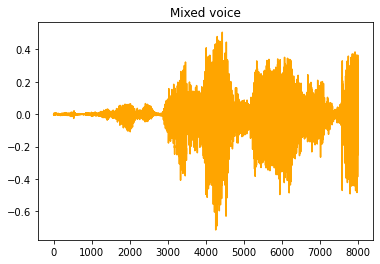

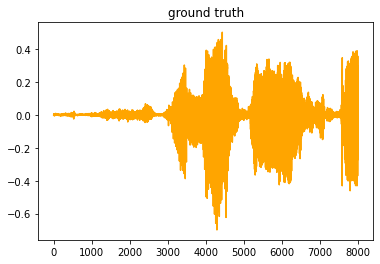

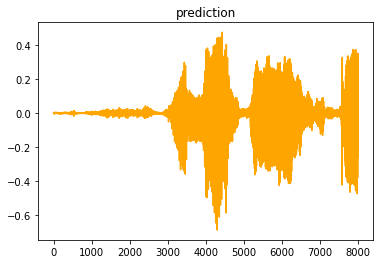

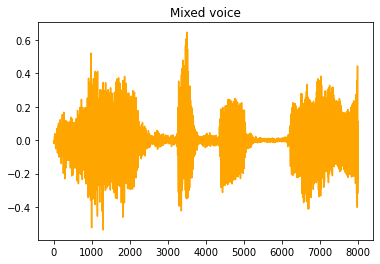

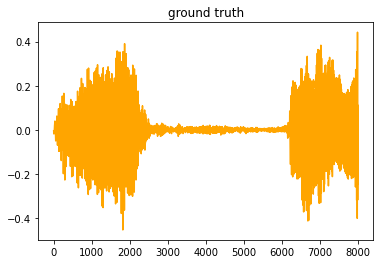

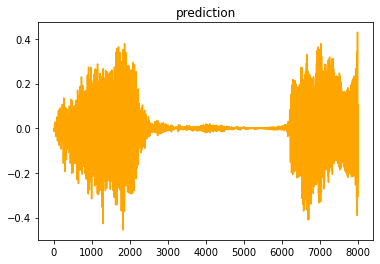

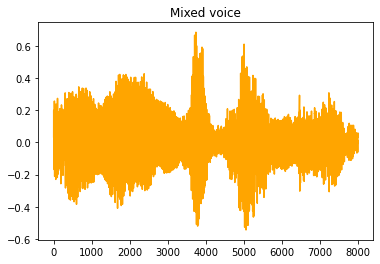

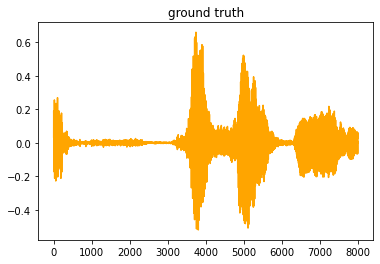

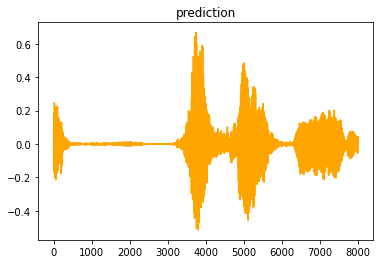

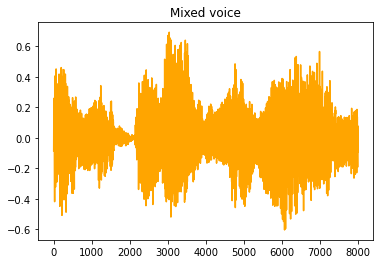

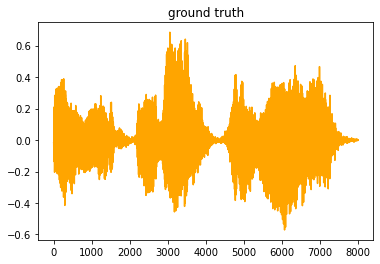

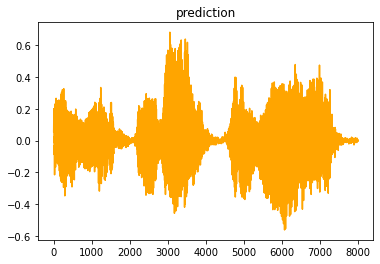

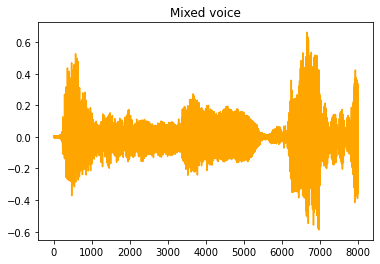

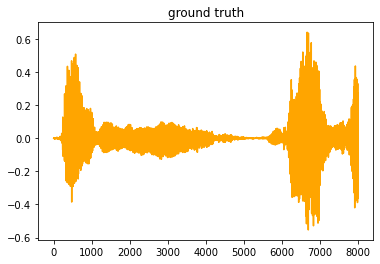

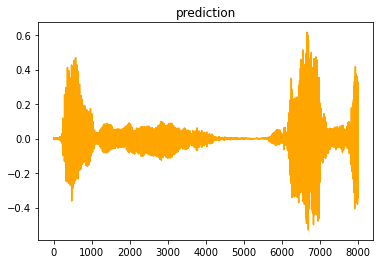

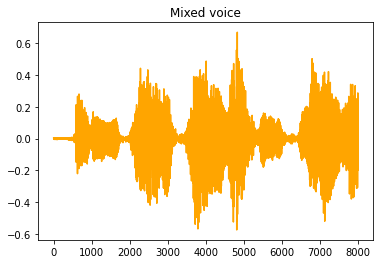

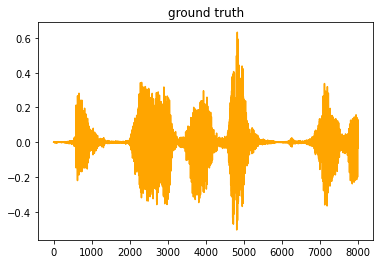

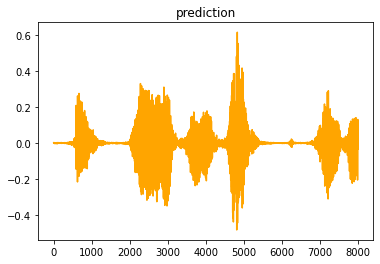

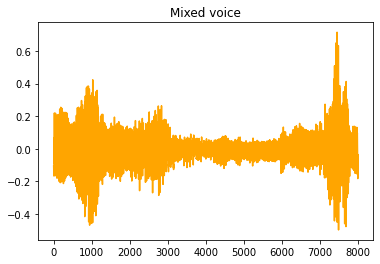

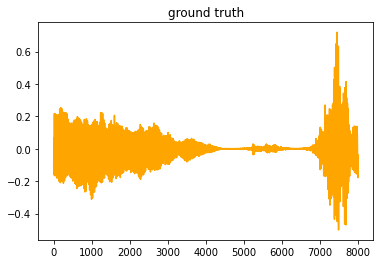

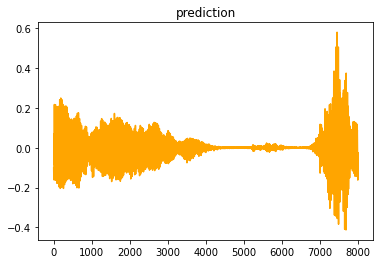

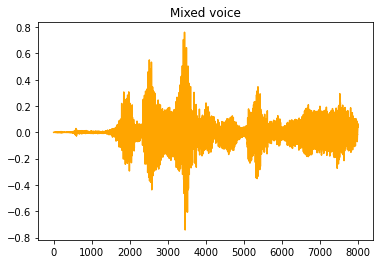

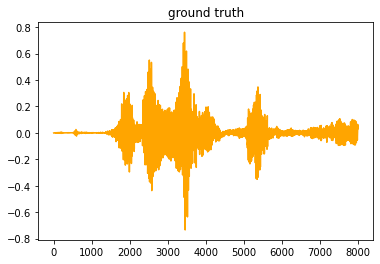

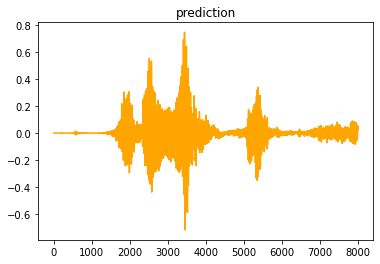

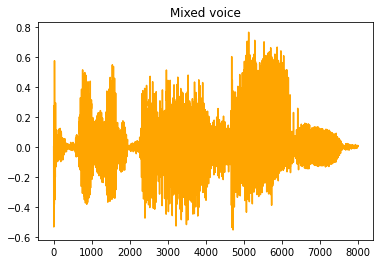

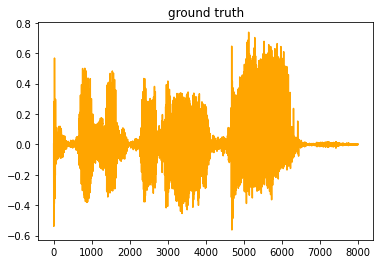

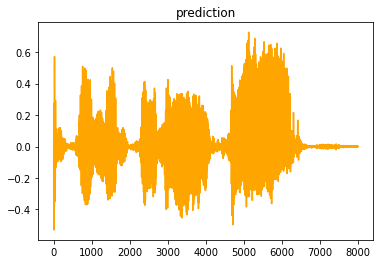

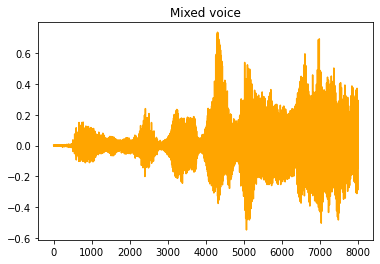

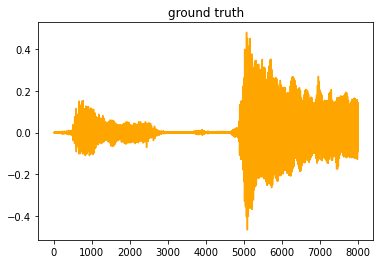

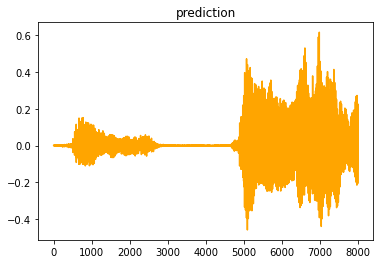

In [0]:
for i in range(30, 40):
  reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
  reconstruct_wav(y_test[i], test_phase[i], "ground truth")
  reconstruct_wav(test_res[i], test_phase[i], "prediction")

In [0]:
# label_0_embeddings = np.expand_dims(embedding_matrix[0, :], axis=0)
# label_1_embeddings = np.expand_dims(embedding_matrix[1, :], axis=0)

# for i in range(20, 30):
#   label_0_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_0_embeddings, axis=0)])
#   label_1_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_1_embeddings, axis=0)])

#   reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
#   reconstruct_wav(y_test[i], test_phase[i], "ground truth")
#   reconstruct_wav(label_0_res[0], test_phase[i], "prediction: label 0")
#   reconstruct_wav(label_1_res[0], test_phase[i], "prediction: label 1")